In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, GlobalAveragePooling2D, Dense, Reshape, multiply, Input, LeakyReLU
from tensorflow.keras.models import Model

In [ ]:
!kaggle datasets download -d adipuli2004/dehazing-and-desmoking

Dataset URL: https://www.kaggle.com/datasets/adipuli2004/dehazing-and-desmoking
License(s): MIT
100% 11.7G/11.7G [02:16<00:00, 120MB/s]
100% 11.7G/11.7G [02:16<00:00, 92.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dehazing-and-desmoking.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
ls '/content/dataset/45'

hazy.jpg  mask.jpg  original.jpg


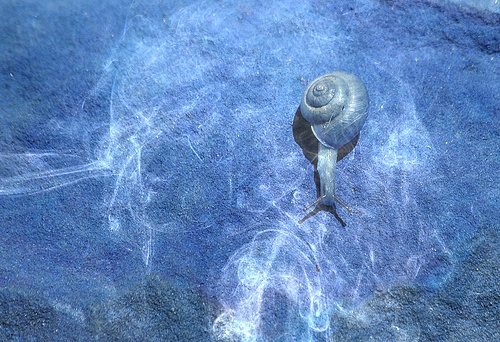

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
samp_hazy = cv2.imread('/content/dataset/45/hazy.jpg')
samp_hazy = cv2.cvtColor(samp_hazy, cv2.COLOR_BGR2RGB)
samp_clear = cv2.imread('/content/dataset/45/original.jpg')
samp_clear = cv2.cvtColor(samp_clear, cv2.COLOR_BGR2RGB)

cv2_imshow(samp_hazy)

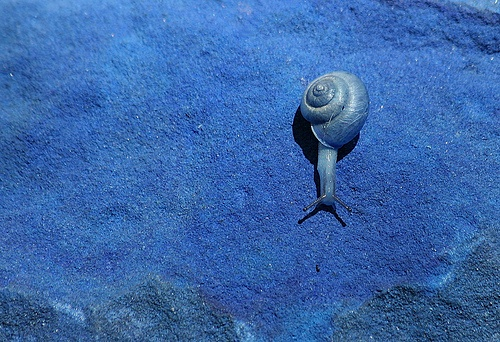

In [ ]:
cv2_imshow(samp_clear)

In [ ]:
import os
import pandas as pd
import csv

with open('/content/folder_df.csv', 'w') as csvfile:
  wrtr = csv.writer(csvfile)
  wrtr.writerow(['folder_path'])

  for dirpath, dirnames, filenames in os.walk('/content/dataset'):
      wrtr.writerow([str(dirpath)])

In [ ]:
df = pd.read_csv('/content/folder_df.csv')
df.head()

,folder_path
0,/content/dataset
1,/content/dataset/3899
2,/content/dataset/50426
3,/content/dataset/7321
4,/content/dataset/28760


In [ ]:
df.tail()

,folder_path
50975,/content/dataset/50828
50976,/content/dataset/49237
50977,/content/dataset/46497
50978,/content/dataset/39009
50979,/content/dataset/6313


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50980 entries, 0 to 50979
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   folder_path  50980 non-null  object
dtypes: object(1)
memory usage: 398.4+ KB


In [ ]:
folders = np.array(df['folder_path'])
val_dat_arr = folders[5000:6001]
folders = folders[1:2500]

In [ ]:
folders[0] + '/hazy.jpg'

'/content/dataset/3899/hazy.jpg'

In [ ]:
from PIL import Image

def load_images_from_folder(folder):


    folder = tf.convert_to_tensor(folder, dtype=tf.string)

    hazy_image_path = tf.strings.join([folder, 'hazy.jpg'], separator='/')
    clear_image_path = tf.strings.join([folder, 'original.jpg'], separator='/')

    '''print(f"Hazy Image Path: {hazy_image_path}")
    print(f"Clear Image Path: {clear_image_path}")

    # Check if files exist
    if not os.path.exists(hazy_image_path):
        raise FileNotFoundError(f"Hazy image not found at path: {hazy_image_path}")
    if not os.path.exists(clear_image_path):
        raise FileNotFoundError(f"Clear image not found at path: {clear_image_path}")
'''
    hazy_image = tf.io.read_file(hazy_image_path)
    hazy_image = tf.image.decode_jpeg(hazy_image, channels=3)
    clear_image = tf.io.read_file(clear_image_path)
    clear_image = tf.image.decode_jpeg(clear_image, channels=3)

    hazy_image = tf.image.resize(hazy_image, (256, 256)) / 255.0
    clear_image = tf.image.resize(clear_image, (256, 256)) / 255.0

    return hazy_image, clear_image

In [ ]:
def create_dataset_from_folders(folders):

    dataset = tf.data.Dataset.from_tensor_slices(folders)



    dataset = dataset.map(load_images_from_folder, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.shuffle(len(folders)).batch(32)

    return dataset

In [ ]:
dataset = create_dataset_from_folders(folders)

In [ ]:
import tensorflow as tf
test_folder = folders[0]
hazy_image, clear_image = load_images_from_folder(test_folder)

# Print shapes to verify loading
print("Hazy Image Shape:", hazy_image.shape)
print("Clear Image Shape:", clear_image.shape)

Hazy Image Shape: (256, 256, 3)
Clear Image Shape: (256, 256, 3)


In [ ]:
from re import S
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, GlobalAveragePooling2D, Dense, Reshape, multiply, Input, LeakyReLU
from tensorflow.keras.models import Model
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    #up6 = SEBlock()(up6)
    up6 = concatenate([up6, conv4], axis=3)
    up6 = Conv2D(1024, 3, padding='same')(up6)
    up6 = LeakyReLU(alpha=0.2)(up6)
    up6 = Conv2D(512, 3, padding='same')(up6)
    up6 = LeakyReLU(alpha=0.2)(up6)

    up7 = UpSampling2D(size=(2, 2))(up6)
    #up7 = SEBlock()(up7)
    up7 = concatenate([up7, conv3], axis=3)
    up7 = Conv2D(512, 3, padding='same')(up7)
    up7 = LeakyReLU(alpha=0.2)(up7)
    up7 = Conv2D(256, 3, padding='same')(up7)
    up7 = LeakyReLU(alpha=0.2)(up7)

    up8 = UpSampling2D(size=(2, 2))(up7)
    #up8 = SEBlock()(up8)
    up8 = concatenate([up8, conv2], axis=3)
    up8 = Conv2D(256, 3, padding='same')(up8)
    up8 = LeakyReLU(alpha=0.2)(up8)
    up8 = Conv2D(128, 3, padding='same')(up8)
    up8 = LeakyReLU(alpha=0.2)(up8)

    up9 = UpSampling2D(size=(2, 2))(up8)
    #up9 = SEBlock(up9)
    up9 = concatenate([up9, conv1], axis=3)
    up9 = Conv2D(128, 3, padding='same')(up9)
    up9 = LeakyReLU(alpha=0.2)(up9)
    up9 = Conv2D(64, 3, padding='same')(up9)
    up9 = LeakyReLU(alpha=0.2)(up9)
    up9 = Conv2D(64, 3, padding='same')(up9)
    up9 = LeakyReLU(alpha=0.2)(up9)

    outputs = Conv2D(3, 1, activation='sigmoid')(up9)

    model = Model(inputs, outputs)
    return model

In [ ]:
generator = unet_model()
#generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_25 (LeakyReLU)  (None, 256, 256, 64)         0         ['conv2d_26[0][0]']           
                                                                                                  
 conv2d_27 (Conv2D)          (None, 256, 256, 64)         36928     ['leaky_re_lu_25[0][0]']      
                                                                                            

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense

In [ ]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32, 4, strides=(2,2), padding='same', input_shape=[256,256,3]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 4, strides=(2,2), padding='same', input_shape=[256,256,3]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 4, strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 4, strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, 4, strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(1024, 4, strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model



In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 128, 128, 32)      1568      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_47 (Conv2D)          (None, 64, 64, 64)        32832     
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 128)      

In [ ]:
gan_input = Input(shape=(256, 256, 3))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)

In [ ]:
gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 256, 256, 3)       43950723  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 11193825  
                                                                 
Total params: 55144548 (210.36 MB)
Trainable params: 55144548 (210.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
generator_opt = Adam(learning_rate=0.0001)
discriminator_opt = Adam(learning_rate=0.00001)
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()
reconstrunction_loss = tf.keras.losses.MeanSquaredError()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

class ImageDehazing(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, recon_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.recon_loss = recon_loss

    def call(self, inputs, training=False): # Add the call method
        # Define how the model processes inputs here
        generated_image = self.generator(inputs, training=training)
        return generated_image


    def train_step(self, batch):
        hazy_imgs, clear_imgs = batch

        # Generate fake images
        fake_images = self.generator(hazy_imgs, training=True)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(clear_imgs, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Compute discriminator loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Backpropagate discriminator gradients
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_imgs = self.generator(hazy_imgs, training=True)
            fake_pred = self.discriminator(gen_imgs, training=True)

            g_adv_loss = self.g_loss(tf.ones_like(fake_pred), fake_pred)
            g_recon_loss = self.recon_loss(clear_imgs, gen_imgs)

            # Compute generator loss
            total_g_loss = g_adv_loss + g_recon_loss

        # Backpropagate generator gradients
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}


In [ ]:
dehazer = ImageDehazing(generator, discriminator)

In [ ]:
dehazer.compile(generator_opt, discriminator_opt, generator_loss, discriminator_loss, reconstrunction_loss, metrics=['accuracy'])

In [ ]:
dehazer.build(input_shape=(None, 256, 256, 3))

In [ ]:
dehazer.summary()

Model: "image_dehazing_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 256, 256, 3)       43950723  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 11193825  
                                                                 
Total params: 55144548 (210.36 MB)
Trainable params: 55144548 (210.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.tf',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1,
    save_format = 'tf'
)

In [ ]:
val_dat = create_dataset_from_folders(val_dat_arr)


In [ ]:
history = dehazer.fit(dataset, epochs = 10, validation_data=val_dat, callbacks=[checkpoint_callback])

Epoch 1/10
79/79 [==============================] - ETA: 0s - d_loss: 0.6855 - g_loss: 0.6464 
Epoch 1: val_loss improved from inf to 0.00000, saving model to model_checkpoint.tf


79/79 [==============================] - 2117s 27s/step - d_loss: 0.6851 - g_loss: 0.6457 - val_loss: 0.0000e+00 - val_accuracy: 0.3105
Epoch 2/10
79/79 [==============================] - ETA: 0s - d_loss: 0.5585 - g_loss: 0.4761 
Epoch 2: val_loss did not improve from 0.00000
79/79 [==============================] - 2121s 27s/step - d_loss: 0.5563 - g_loss: 0.4741 - val_loss: 0.0000e+00 - val_accuracy: 0.3484
Epoch 3/10
79/79 [==============================] - ETA: 0s - d_loss: 0.2880 - g_loss: 0.2578 
Epoch 3: val_loss did not improve from 0.00000
79/79 [==============================] - 2103s 27s/step - d_loss: 0.2873 - g_loss: 0.2576 - val_loss: 0.0000e+00 - val_accuracy: 0.3487
Epoch 4/10
79/79 [==============================] - ETA: 0s - d_loss: 0.2829 - g_loss: 0.2453 
Epoch 4: val_loss did not improve from 0.00000
79/79 [==============================] - 2105s 27s/step - d_loss: 0.2838 - g_loss: 0.2452 - val_loss: 0.0000e+00 - val_accuracy: 0.3435
Epoch 5/10
 2/79 [............

KeyboardInterrupt: 